# Toyota Yaris II -  price prediction


In [55]:
import pandas as pd
import numpy as np
import sqlite3

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

def get_view_data():
    sql_query = """SELECT * FROM v_cars"""
    conn = sqlite3.connect("pythonsqlite.db")
    data = pd.read_sql_query(sql_query, conn)
    conn.close()
    return data

def get_data():
    sql_query ="""
SELECT 
    all_offers.offer_id,otomoto_all.s_date, otomoto_all.e_date, all_offers.private_business, all_offers.region,
    all_offers.city, all_offers.model, all_offers.year, all_offers.mileage, all_offers.engine_capacity, all_offers.vin,
    all_offers.fuel_type, all_offers.engine_power, all_offers.gearbox, all_offers.transmission, all_offers.door_count,
    all_offers.nr_seats, all_offers.color, all_offers.features,otomoto_all.price, all_offers.price_raw, all_offers.currency, 
    all_offers.country_origin, all_offers.registration
FROM 
    otomoto_all, all_offers
WHERE 
    otomoto_all.uid = all_offers.uid; 
"""

    conn = sqlite3.connect("pythonsqlite.db")
    data = pd.read_sql_query(sql_query, conn)
    conn.close()
    return data

#%time df = get_data() #~13 ms
%time df = get_view_data() #~13 ms

#%time for i in range(3000): df = get_data()

df.head(3)

Wall time: 27 ms


,offer_id,s_date,e_date,private_business,region,city,model,year,mileage,engine_capacity,...,transmission,door_count,nr_seats,color,features,price,price_raw,currency,country_origin,registration
0,6005738641,2020-04-17,2020-04-24,business,malopolskie,krakow,yaris,2009,111000,1000,...,front-wheel,5,5,grey,0,6200,6200.0,0,f,0
1,6018694885,2020-04-17,2020-04-24,business,warminsko-mazurskie,ostroda,yaris,2008,45706,998,...,0,3,5,white,abs central-lock electronic-immobiliser front-...,4700,4700.0,0,pl,0
2,6025678407,2020-04-17,2020-04-24,business,mazowieckie,milanowek,yaris,2009,174000,1300,...,0,5,5,silver,abs cd central-lock front-electric-windows ele...,19800,19800.0,0,0,0


In [56]:
df.columns

Index(['offer_id', 's_date', 'e_date', 'private_business', 'region', 'city',
       'model', 'year', 'mileage', 'engine_capacity', 'vin', 'fuel_type',
       'engine_power', 'gearbox', 'transmission', 'door_count', 'nr_seats',
       'color', 'features', 'price', 'price_raw', 'currency', 'country_origin',
       'registration'],
      dtype='object')

In [57]:
def optimize_df():
    #df['offer_id'] = df['offer_id'].astype(np.uint32)
    df['offer_id'] = pd.to_numeric (df['offer_id'], downcast='unsigned')
    df['s_date'] = pd.to_datetime(df['s_date']) 
    df['e_date'] = pd.to_datetime(df['e_date']) 
    df['year'] = pd.to_numeric(df['year'], downcast='unsigned')
    df['mileage'] = pd.to_numeric(df['mileage'], downcast='unsigned')
    df['engine_capacity'] = pd.to_numeric(df['engine_capacity'], downcast='unsigned')
    df['engine_power'] = pd.to_numeric(df['engine_power'], downcast='unsigned')
    df['door_count'] = pd.to_numeric(df['door_count'], downcast='unsigned')
    df['nr_seats'] = pd.to_numeric(df['nr_seats'], downcast='unsigned')
    df['price'] = pd.to_numeric(df['price'], downcast='float')
    df['price_raw'] = pd.to_numeric(df['price_raw'], downcast='float')
    
%time optimize_df()    

Wall time: 12 ms


In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 283 entries, 0 to 282
Data columns (total 80 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   offer_id                       283 non-null    uint64        
 1   s_date                         283 non-null    datetime64[ns]
 2   e_date                         283 non-null    datetime64[ns]
 3   private_business               283 non-null    object        
 4   region                         283 non-null    object        
 5   city                           283 non-null    object        
 6   model                          283 non-null    object        
 7   year                           283 non-null    uint16        
 8   mileage                        283 non-null    uint32        
 9   engine_capacity                283 non-null    uint16        
 10  vin                            283 non-null    object        
 11  fuel_type          

In [59]:
def check_missing():
    for column in df.columns:
        missing = column, df[column].isnull().sum()
        if missing[1] == 0: continue

        print(missing)
        
check_missing()

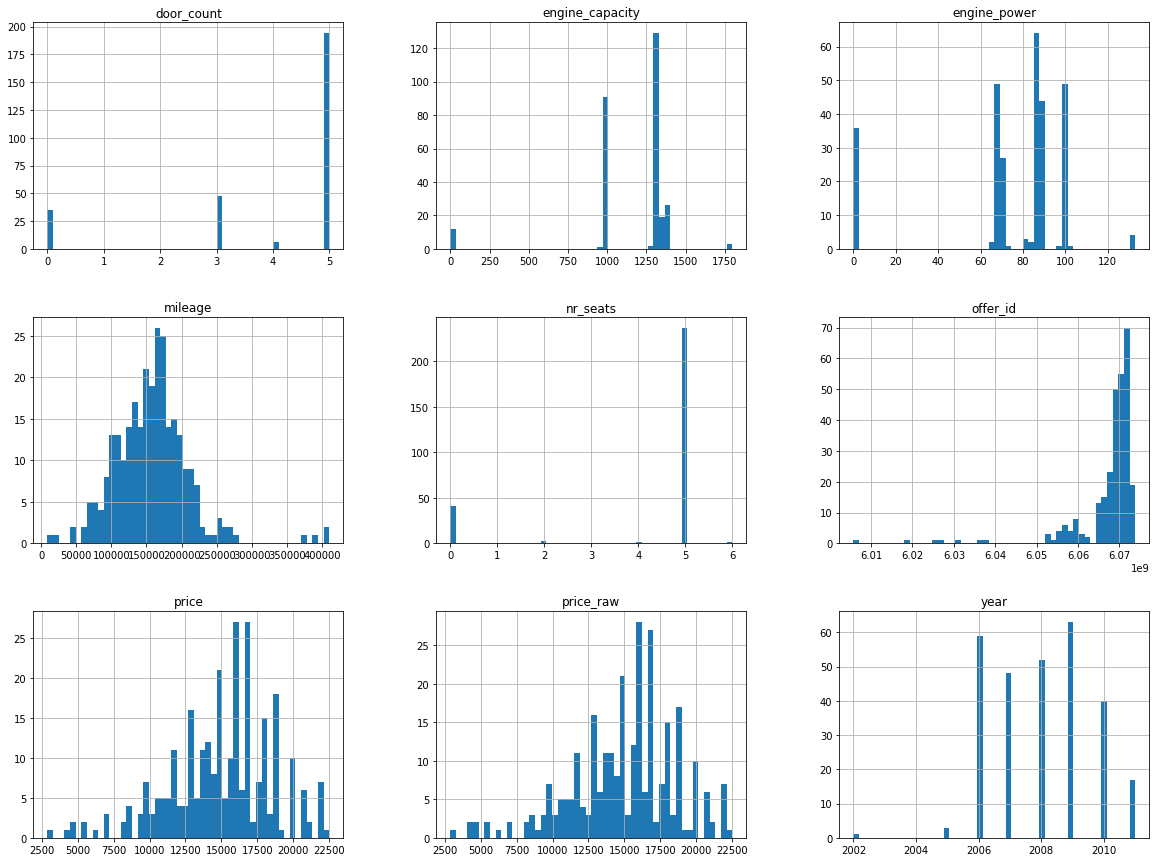

In [60]:
df.hist(bins=50,figsize=(20,15))
plt.show()

## Feature engineering

In [61]:
def general_features():
    df['duration'] = (df['e_date'] - df['s_date']).dt.days.astype(np.uint16)
    df['price_chng'] = (df['price'] - df['price_raw'])
    #df['active'] = df['duration'].apply()
    
%time general_features()

Wall time: 4 ms


In [62]:
df.sample(3)

,offer_id,s_date,e_date,private_business,region,city,model,year,mileage,engine_capacity,...,nr_seats,color,features,price,price_raw,currency,country_origin,registration,duration,price_chng
117,6069204066,2020-04-17,2020-04-24,private,mazowieckie,pruszkow,yaris,2008,154288,1296,...,5,blue,abs cd central-lock front-electric-windows ele...,16999.0,16999.0,0,pl,LRY 84LR,7,0.0
30,6059503917,2020-04-17,2020-04-24,business,mazowieckie,otwock,yaris,2007,259000,1000,...,5,other,abs cd central-lock electronic-rearview-mirror...,10999.0,10999.0,0,pl,0,7,0.0
208,6071449892,2020-04-17,2020-04-24,business,warminsko-mazurskie,mragowo,yaris,2006,9100,998,...,5,black,abs cd central-lock front-electric-windows ele...,15200.0,15200.0,0,0,0,7,0.0


In [63]:
df[df['price_chng']!=0].head()

,offer_id,s_date,e_date,private_business,region,city,model,year,mileage,engine_capacity,...,nr_seats,color,features,price,price_raw,currency,country_origin,registration,duration,price_chng
76,6067672282,2020-04-17,2020-04-24,business,wielkopolskie,ostrzeszow,yaris,2007,410000,998,...,2,silver,abs cd central-lock electronic-immobiliser fro...,5400.0,4390.240234,0,pl,0,7,1009.759766
82,6067981935,2020-04-17,2020-04-24,business,zachodniopomorskie,bialogard,yaris,2006,112000,1298,...,5,black,abs cd central-lock front-electric-windows ele...,14500.0,14900.000000,0,0,0,7,-400.000000
203,6071362168,2020-04-17,2020-04-24,business,malopolskie,brzesko,yaris,2006,202910,1298,...,5,silver,abs cd central-lock front-electric-windows ele...,13999.0,14499.000000,0,d,0,7,-500.000000
210,6071457723,2020-04-17,2020-04-24,private,malopolskie,wieliczka,yaris,2009,133000,1329,...,0,red,abs cd central-lock front-electric-windows ele...,18900.0,19500.000000,0,0,0,7,-600.000000
233,6071895163,2020-04-17,2020-04-24,private,slaskie,myszkow,yaris,2009,130000,1329,...,5,black,abs cd central-lock front-electric-windows ele...,15400.0,15900.000000,0,d,0,7,-500.000000


Wall time: 59 ms


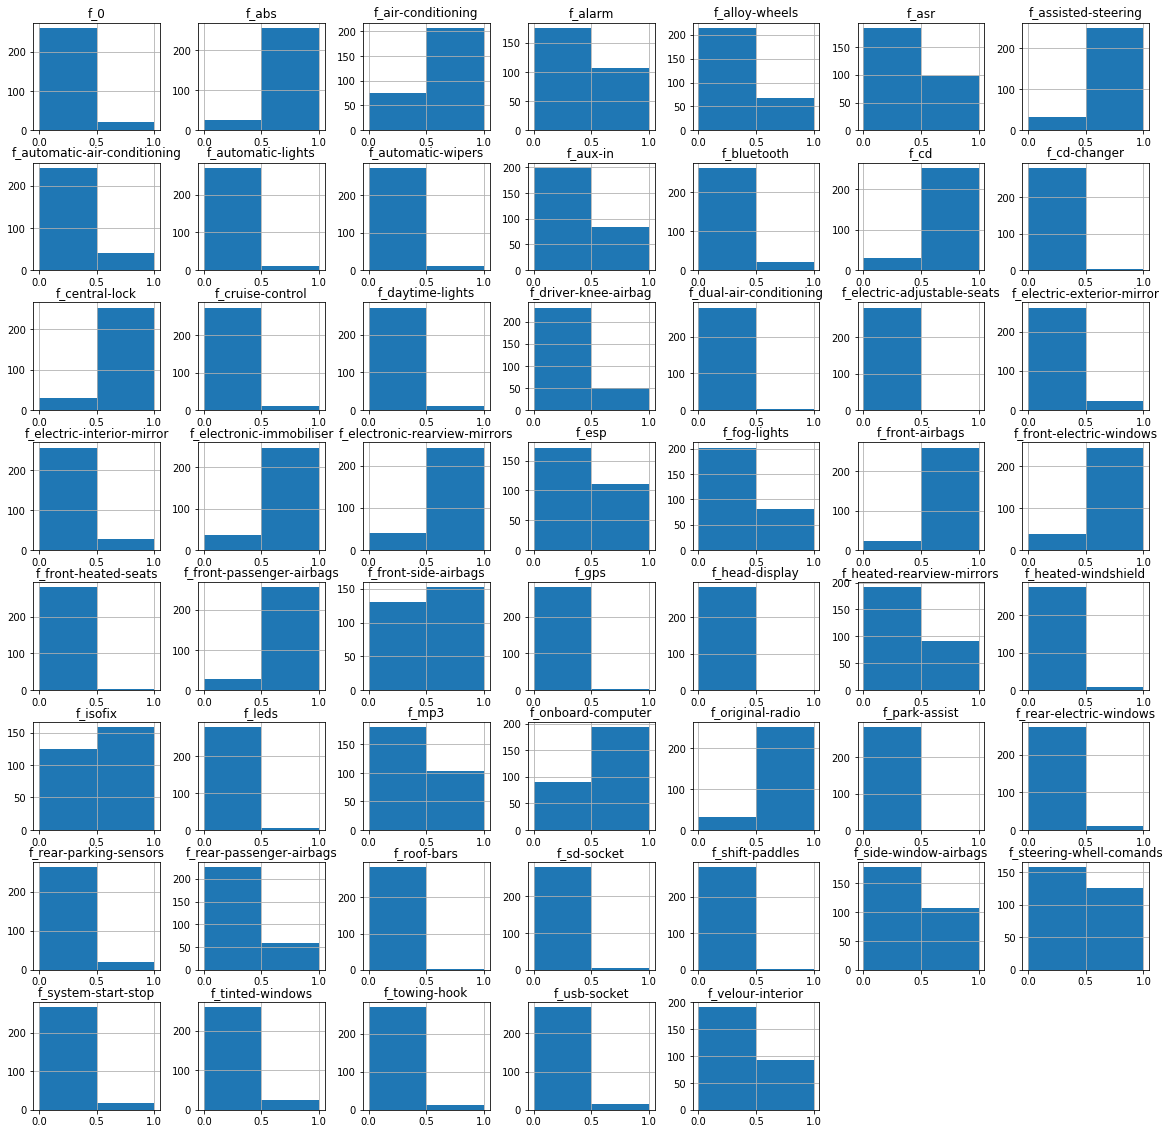

In [64]:
#car features
def benefits_to_set(value):
    if str(value) == 'nan': return set(["nan"])
    return {attr.lower().strip() for attr in value}
    
def norm_name(name):
    return 'f_{0}'.format( name.lower().strip() )

def feature_columns(): 
    benefits_series = df['features'].str.split(' ').map(benefits_to_set)
    all_benefits = {benefit for row in benefits_series for benefit in row}
    
    feat_names = [norm_name(x) for x in all_benefits]
    
    for benefit in all_benefits:
        df[ norm_name(benefit) ] = benefits_series.map(lambda x: benefit in x).astype(np.int8)
    
    return feat_names

%time f = feature_columns()


df[f].hist(bins=2,figsize=(20,20))
plt.show()

In [65]:
#df.info()

In [66]:
#df[ [norm_name(x) for x in all_benefits] ].sample(3)

In [67]:
df.sample(3)

,offer_id,s_date,e_date,private_business,region,city,model,year,mileage,engine_capacity,...,f_automatic-air-conditioning,f_air-conditioning,f_central-lock,f_rear-parking-sensors,f_heated-rearview-mirrors,f_electric-adjustable-seats,f_cruise-control,f_dual-air-conditioning,f_front-passenger-airbags,f_electronic-rearview-mirrors
15,6056320484,2020-04-17,2020-04-24,private,podkarpackie,jaslo,yaris,2009,160000,1400,...,0,1,1,0,0,0,0,0,1,1
230,6071889980,2020-04-17,2020-04-24,business,podkarpackie,jaroslaw,yaris,2008,152282,998,...,0,1,1,1,0,0,0,0,1,1
9,6053382236,2020-04-17,2020-04-24,business,podkarpackie,stalowa-wola,yaris,2005,155000,1298,...,0,1,1,0,1,0,0,0,1,1


## Wizualizacja

In [68]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from bokeh.plotting import figure 
import bokeh_catplot
#from bokeh.charts import Histogram
from bokeh.io import output_notebook, show


output_notebook(resources=None, verbose=False, hide_banner=True)

In [69]:
def plot_bokeh():
    p = figure(plot_width=400, plot_height=400)

    # add a circle renderer with a size, color, and alpha
    p.circle([1, 2, 3, 4, 5], [6, 7, 2, 4, 5], size=20, color="navy", alpha=0.5)

    
    # show the results
    show(p)

def plot_hist():
    # http://justinbois.github.io/bootcamp/2019/lessons/l23_high_level_plotting.html
    # https://github.com/justinbois/bokeh-catplot
    p = bokeh_catplot.histogram(data=df['price'],cats=None,val='price', bins=20)
    show(p)
#%time plot_bokeh() 

%time plot_hist()

Wall time: 56 ms


### Pojemność silnika

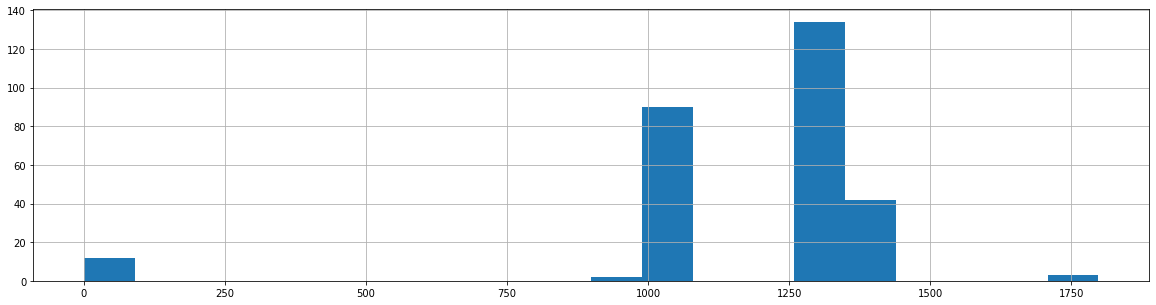

In [70]:
disp_counter = df['engine_capacity'].nunique()
df['engine_capacity'].hist(bins=disp_counter,figsize=(20,5))
plt.show()

### Czas trwania ogłoszenia

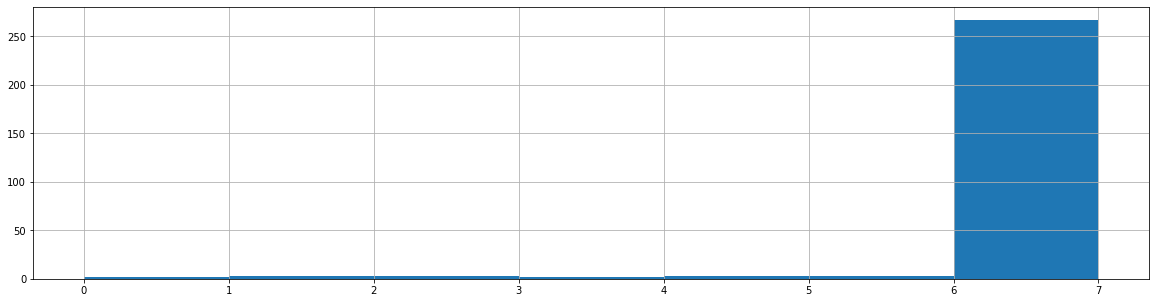

In [71]:
offer_duration = df['duration'].max()
df['duration'].hist(bins=offer_duration,figsize=(20,5))
plt.show()

### Cena końcowa

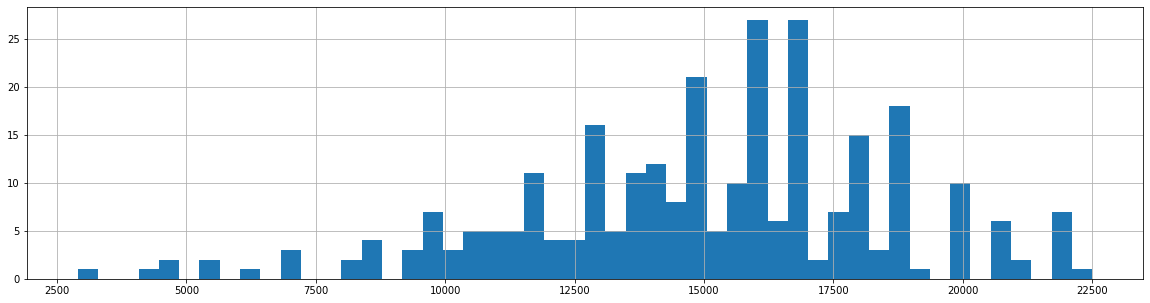

In [72]:
df['price'].hist(bins=50,figsize=(20,5))
plt.show()

In [73]:
filter_max = np.percentile(df['price'],99)
filter_max

21999.18

### Cena końcowa - 99 percentyl

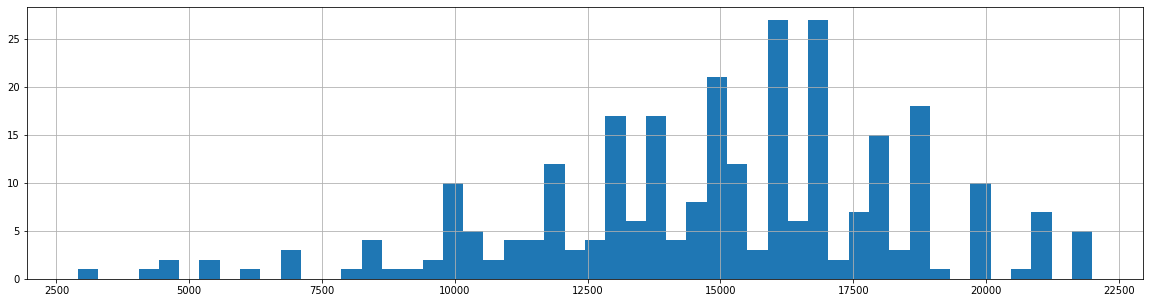

In [74]:
df_filter = df[df['price'] < filter_max]
df_filter['price'].hist(bins=50,figsize=(20,5))
plt.show()

### Przebieg

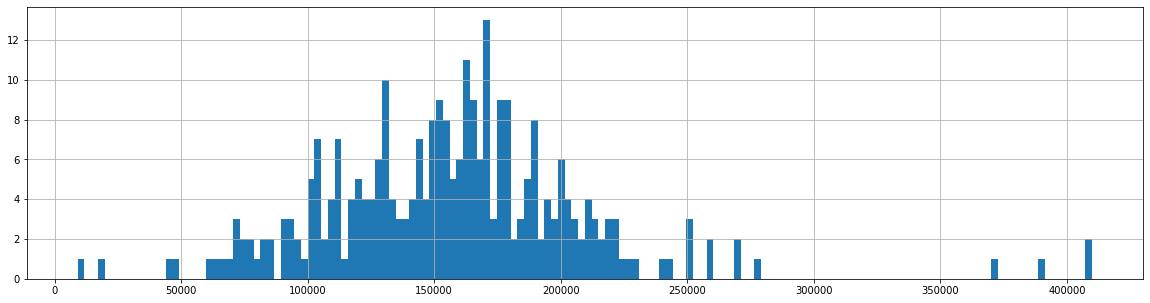

In [75]:
df['mileage'].hist(bins=150,figsize=(20,5))
plt.show()

### Przebieg - 99 percentyl

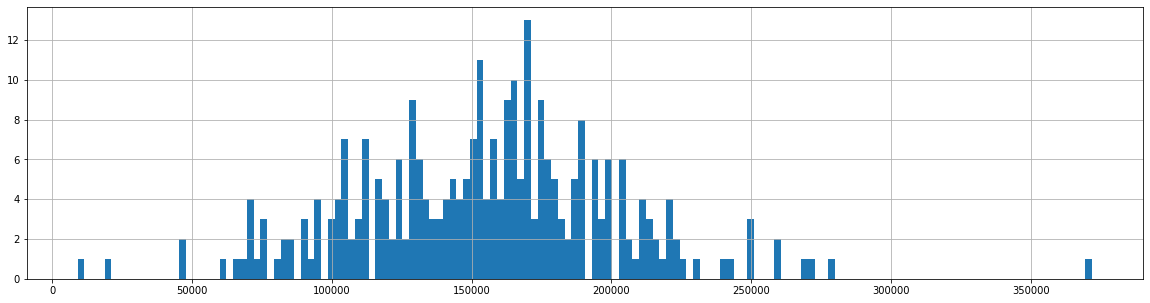

In [76]:
df_mileage = df[df['mileage'] < np.percentile(df['mileage'],99)]
df_mileage['mileage'].hist(bins=150,figsize=(20,5))
plt.show()

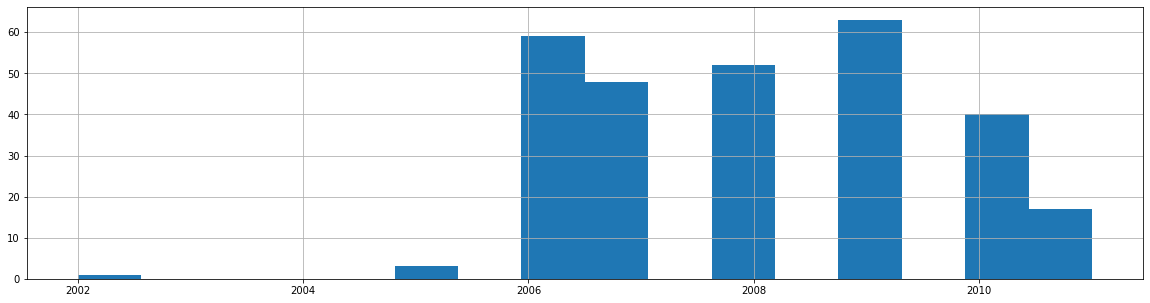

In [77]:
offer_year = df['year'].nunique()*2
df['year'].hist(bins=offer_year,figsize=(20,5))
plt.show()

In [78]:
#x=[2009,2010,2011]
#y=[200,300,400]
#df = pd.DataFrame(dict(x=x, y=y))

#print(type(df))

#ax = sns.barplot(x=x, y=y)

In [88]:
df[df['year'] == 2009 ].shape[0]

63

Wall time: 143 ms


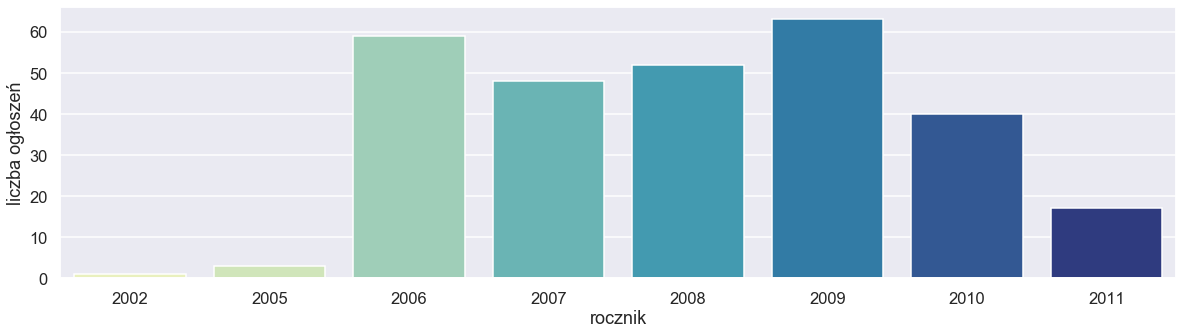

In [87]:
def plot_year():
    year_list = df['year'].unique()

    x = []
    y = []
    for i in year_list:
        x.append(i)
        y.append(df[df['year'] == i ].shape[0])
    
    sdf = pd.DataFrame(dict(x=x, y=y)).sort_values(by=['x'])

    sns.set_style("darkgrid")  
    plt.figure(figsize=(20,5))
    ax = sns.barplot(x=x, y=y, data=sdf, palette=("YlGnBu"))
    ax.set(xlabel='rocznik', ylabel='liczba ogłoszeń')
    sns.set_context("talk")
    plt.savefig('sns.png')
    
%time plot_year()


## ML

In [78]:
np.random.seed(0)
import xgboost as xgb

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score, cross_validate, cross_val_predict
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, classification_report
import scikitplot as skplt

xgb_params = {
    'max_depth' : 5, 
    'n_estimators' : 100, 
    'learning_rate' : 0.3, 
    'random_state' : 0
}

model = xgb.XGBRegressor(**xgb_params)

['year', 'mileage', 'engine_capacity', 'engine_power', 'door_count', 'nr_seats', 'duration', 'price_chng', 'f_onboard-computer', 'f_0', 'f_asr', 'f_esp', 'f_head-display', 'f_park-assist', 'f_roof-bars', 'f_bluetooth', 'f_daytime-lights', 'f_electric-interior-mirror', 'f_sd-socket', 'f_side-window-airbags', 'f_heated-rearview-mirrors', 'f_automatic-air-conditioning', 'f_aux-in', 'f_automatic-wipers', 'f_front-electric-windows', 'f_front-passenger-airbags', 'f_gps', 'f_front-heated-seats', 'f_isofix', 'f_central-lock', 'f_driver-knee-airbag', 'f_alarm', 'f_alloy-wheels', 'f_heated-windshield', 'f_electronic-rearview-mirrors', 'f_electronic-immobiliser', 'f_assisted-steering', 'f_leds', 'f_fog-lights', 'f_rear-electric-windows', 'f_shift-paddles', 'f_velour-interior', 'f_electric-adjustable-seats', 'f_cd-changer', 'f_mp3', 'f_front-airbags', 'f_rear-parking-sensors', 'f_cd', 'f_rear-passenger-airbags', 'f_steering-whell-comands', 'f_tinted-windows', 'f_system-start-stop', 'f_dual-air-con

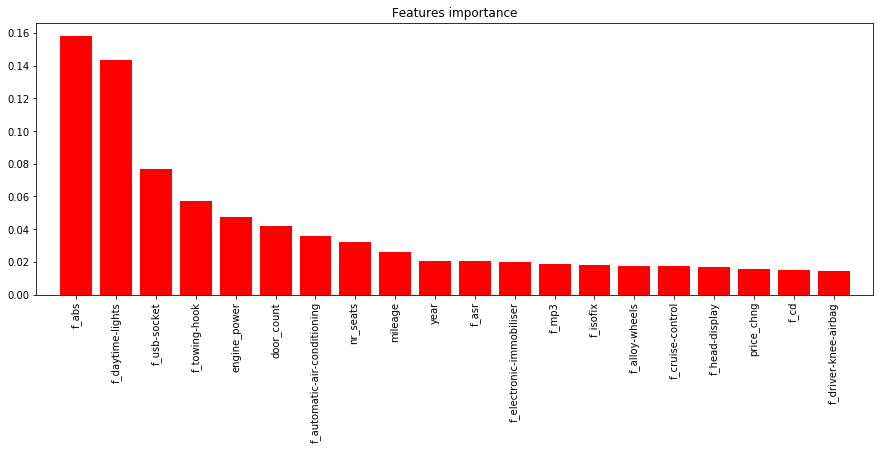

In [79]:
def get_feats(df):
    feats = df.select_dtypes([np.number, np.bool]).columns
    black_list = ['price', 'price_raw', 'offer_id']
    return [x for x in feats if x not in black_list]

def get_cat_feats(df):
    cat_feats = df.select_dtypes(include=[np.object]).columns
    black_list = ['features', 'model']
    cat_feats_list =  [x for x in cat_feats if x not in black_list]

    for cat_feat in cat_feats_list:
        df['{0}_cat'.format(cat_feat)] = pd.factorize( df[cat_feat] )[0]

    
feats = get_feats(df)
print(feats)

X = df[feats].values
y = df['price'].values


def simple_split_model(model, X,y):
    #train and predict
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    #print(confusion_matrix(y_test.astype(int), y_pred.astype(int)))
    #print(classification_report(y_test.astype(int), y_pred.astype(int)))   
    #print(mean_squared_error(y_test.astype(int), y_pred.astype(int)))
    
    skplt.estimators.plot_feature_importances(model, feature_names=feats, title='Features importance', x_tick_rotation=90, figsize=(15, 5));
    #skplt.estimators.plot_learning_curve(model, X_train, y_train,'Learning Curve',cv=5);
    #xgb.plot_importance(model.get_booster(), importance_type='gain')

%time simple_split_model(model, X, y)

In [80]:
get_cat_feats(df)
feats = get_feats(df)
print(feats)

['year', 'mileage', 'engine_capacity', 'engine_power', 'door_count', 'nr_seats', 'duration', 'price_chng', 'f_onboard-computer', 'f_0', 'f_asr', 'f_esp', 'f_head-display', 'f_park-assist', 'f_roof-bars', 'f_bluetooth', 'f_daytime-lights', 'f_electric-interior-mirror', 'f_sd-socket', 'f_side-window-airbags', 'f_heated-rearview-mirrors', 'f_automatic-air-conditioning', 'f_aux-in', 'f_automatic-wipers', 'f_front-electric-windows', 'f_front-passenger-airbags', 'f_gps', 'f_front-heated-seats', 'f_isofix', 'f_central-lock', 'f_driver-knee-airbag', 'f_alarm', 'f_alloy-wheels', 'f_heated-windshield', 'f_electronic-rearview-mirrors', 'f_electronic-immobiliser', 'f_assisted-steering', 'f_leds', 'f_fog-lights', 'f_rear-electric-windows', 'f_shift-paddles', 'f_velour-interior', 'f_electric-adjustable-seats', 'f_cd-changer', 'f_mp3', 'f_front-airbags', 'f_rear-parking-sensors', 'f_cd', 'f_rear-passenger-airbags', 'f_steering-whell-comands', 'f_tinted-windows', 'f_system-start-stop', 'f_dual-air-con